In [1]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

## <span id="1"></span> ** 1. Importing Libraries and Reading the Dataset **

In [2]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
import gc, datetime, random
import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.metrics import roc_auc_score

def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

SEED = 42
seed_everything(SEED)
START_DATE = datetime.datetime.strptime('2017-11-30', '%Y-%m-%d')

In [3]:
pd.set_option('display.max_rows', 2000)
pd.set_option('display.max_columns', 2000)

In [4]:
%%time
train_transaction = pd.read_csv('../input/train_transaction.csv', index_col='TransactionID')
test_transaction = pd.read_csv('../input/test_transaction.csv', index_col='TransactionID')

train_identity = pd.read_csv('../input/train_identity.csv', index_col='TransactionID')
test_identity = pd.read_csv('../input/test_identity.csv', index_col='TransactionID')

sample_submission = pd.read_csv('../input/sample_submission.csv', index_col='TransactionID')

train = train_transaction.merge(train_identity, how='left', left_index=True, right_index=True)
test = test_transaction.merge(test_identity, how='left', left_index=True, right_index=True)

print("Train shape: ", train.shape)
print("Test shape: ", test.shape)

y = train['isFraud'].copy()
del train_transaction, train_identity, test_transaction, test_identity

# Drop target, fill in NaNs
train = train.drop('isFraud', axis=1)

Train shape:  (590540, 433)
Test shape:  (506691, 432)
CPU times: user 39.8 s, sys: 5.5 s, total: 45.3 s
Wall time: 45.3 s


In [5]:
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

Memory usage of dataframe is 1970.87 MB
Memory usage after optimization is: 547.26 MB
Decreased by 72.2%
Memory usage of dataframe is 1693.87 MB
Memory usage after optimization is: 480.15 MB
Decreased by 71.7%


## <span id="2"></span> ** 2. Feature Engineering **

### <span id="3"></span> ** Add New Features **

In [6]:
def addNewFeatures(data): 
    data['uid'] = data['card1'].astype(str)+'_'+data['card2'].astype(str)

    data['uid2'] = data['uid'].astype(str)+'_'+data['card3'].astype(str)+'_'+data['card5'].astype(str)

    data['uid3'] = data['uid2'].astype(str)+'_'+data['addr1'].astype(str)+'_'+data['addr2'].astype(str)

    data['D9'] = np.where(data['D9'].isna(),0,1)
    
    return data

train = addNewFeatures(train)
test = addNewFeatures(test)

In [7]:
i_cols = ['card1','card2','card3','card5','uid','uid2','uid3']

for col in i_cols:
    for agg_type in ['mean','std']:
        new_col_name = col+'_TransactionAmt_'+agg_type
        temp_df = pd.concat([train[[col, 'TransactionAmt']], test[[col,'TransactionAmt']]])
        #temp_df['TransactionAmt'] = temp_df['TransactionAmt'].astype(int)
        temp_df = temp_df.groupby([col])['TransactionAmt'].agg([agg_type]).reset_index().rename(
                                                columns={agg_type: new_col_name})

        temp_df.index = list(temp_df[col])
        temp_df = temp_df[new_col_name].to_dict()   

        train[new_col_name] = train[col].map(temp_df)
        test[new_col_name]  = test[col].map(temp_df)

train = train.replace(np.inf,999)
test = test.replace(np.inf,999)

In [8]:
train['TransactionAmt'] = np.log1p(train['TransactionAmt'])
test['TransactionAmt'] = np.log1p(test['TransactionAmt'])

In [9]:
train.head()

,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,uid,uid2,uid3,card1_TransactionAmt_mean,card1_TransactionAmt_std,card2_TransactionAmt_mean,card2_TransactionAmt_std,card3_TransactionAmt_mean,card3_TransactionAmt_std,card5_TransactionAmt_mean,card5_TransactionAmt_std,uid_TransactionAmt_mean,uid_TransactionAmt_std,uid2_TransactionAmt_mean,uid2_TransactionAmt_std,uid3_TransactionAmt_mean,uid3_TransactionAmt_std
TransactionID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2987000,86400,4.242188,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,0,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,T,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

### <span id="4"></span> ** Handle Email Domains **

In [10]:
emails = {'gmail': 'google', 'att.net': 'att', 'twc.com': 'spectrum', 'scranton.edu': 'other', 'optonline.net': 'other',
          'hotmail.co.uk': 'microsoft', 'comcast.net': 'other', 'yahoo.com.mx': 'yahoo', 'yahoo.fr': 'yahoo',
          'yahoo.es': 'yahoo', 'charter.net': 'spectrum', 'live.com': 'microsoft', 'aim.com': 'aol', 'hotmail.de': 'microsoft',
          'centurylink.net': 'centurylink', 'gmail.com': 'google', 'me.com': 'apple', 'earthlink.net': 'other', 
          'gmx.de': 'other', 'web.de': 'other', 'cfl.rr.com': 'other', 'hotmail.com': 'microsoft', 'protonmail.com': 'other',
          'hotmail.fr': 'microsoft', 'windstream.net': 'other', 'outlook.es': 'microsoft', 'yahoo.co.jp': 'yahoo',
          'yahoo.de': 'yahoo', 'servicios-ta.com': 'other', 'netzero.net': 'other', 'suddenlink.net': 'other',
          'roadrunner.com': 'other', 'sc.rr.com': 'other', 'live.fr': 'microsoft', 'verizon.net': 'yahoo',
          'msn.com': 'microsoft', 'q.com': 'centurylink', 'prodigy.net.mx': 'att', 'frontier.com': 'yahoo',
          'anonymous.com': 'other', 'rocketmail.com': 'yahoo', 'sbcglobal.net': 'att', 'frontiernet.net': 'yahoo',
          'ymail.com': 'yahoo', 'outlook.com': 'microsoft', 'mail.com': 'other', 'bellsouth.net': 'other',
          'embarqmail.com': 'centurylink', 'cableone.net': 'other', 'hotmail.es': 'microsoft', 'mac.com': 'apple',
          'yahoo.co.uk': 'yahoo', 'netzero.com': 'other', 'yahoo.com': 'yahoo', 'live.com.mx': 'microsoft', 'ptd.net': 'other',
          'cox.net': 'other', 'aol.com': 'aol', 'juno.com': 'other', 'icloud.com': 'apple'}
us_emails = ['gmail', 'net', 'edu']

for c in ['P_emaildomain', 'R_emaildomain']:
    train[c + '_bin'] = train[c].map(emails)
    test[c + '_bin'] = test[c].map(emails)
    
    train[c + '_suffix'] = train[c].map(lambda x: str(x).split('.')[-1])
    test[c + '_suffix'] = test[c].map(lambda x: str(x).split('.')[-1])
    
    train[c + '_suffix'] = train[c + '_suffix'].map(lambda x: x if str(x) not in us_emails else 'us')
    test[c + '_suffix'] = test[c + '_suffix'].map(lambda x: x if str(x) not in us_emails else 'us')

### <span id="5"></span> ** Handle P Email Domain and R Email Domain **

In [11]:
p = 'P_emaildomain'
r = 'R_emaildomain'
uknown = 'email_not_provided'

def setDomain(df):
    df[p] = df[p].fillna(uknown)
    df[r] = df[r].fillna(uknown)
    
    # Check if P_emaildomain matches R_emaildomain
    df['email_check'] = np.where((df[p]==df[r])&(df[p]!=uknown),1,0)

    df[p+'_prefix'] = df[p].apply(lambda x: x.split('.')[0])
    df[r+'_prefix'] = df[r].apply(lambda x: x.split('.')[0])
    
    return df
    
train=setDomain(train)
test=setDomain(test)

### <span id="6"></span> ** Set Time **

In [12]:
def setTime(df):
    df['TransactionDT'] = df['TransactionDT'].fillna(df['TransactionDT'].median())
    # Temporary
    df['DT'] = df['TransactionDT'].apply(lambda x: (START_DATE + datetime.timedelta(seconds = x)))
    df['DT_M'] = (df['DT'].dt.year-2017)*12 + df['DT'].dt.month
    df['DT_W'] = (df['DT'].dt.year-2017)*52 + df['DT'].dt.weekofyear
    df['DT_D'] = (df['DT'].dt.year-2017)*365 + df['DT'].dt.dayofyear
    
    df['DT_hour'] = df['DT'].dt.hour
    df['DT_day_week'] = df['DT'].dt.dayofweek
    df['DT_day'] = df['DT'].dt.day
    
    return df
    
train=setTime(train)
test=setTime(test)

### <span id="7"></span> ** Handle Browser Version **

In [13]:
train["lastest_browser"] = np.zeros(train.shape[0])
test["lastest_browser"] = np.zeros(test.shape[0])

def setBrowser(df):
    df.loc[df["id_31"]=="samsung browser 7.0",'lastest_browser']=1
    df.loc[df["id_31"]=="opera 53.0",'lastest_browser']=1
    df.loc[df["id_31"]=="mobile safari 10.0",'lastest_browser']=1
    df.loc[df["id_31"]=="google search application 49.0",'lastest_browser']=1
    df.loc[df["id_31"]=="firefox 60.0",'lastest_browser']=1
    df.loc[df["id_31"]=="edge 17.0",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 69.0",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 67.0 for android",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 63.0 for android",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 63.0 for ios",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 64.0",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 64.0 for android",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 64.0 for ios",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 65.0",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 65.0 for android",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 65.0 for ios",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 66.0",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 66.0 for android",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 66.0 for ios",'lastest_browser']=1
    return df

train=setBrowser(train)
test=setBrowser(test)

### <span id="8"></span> ** Handle Device Type **

In [14]:
def setDevice(df):
    df['DeviceInfo'] = df['DeviceInfo'].fillna('unknown_device').str.lower()
    
    df['device_name'] = df['DeviceInfo'].str.split('/', expand=True)[0]

    df.loc[df['device_name'].str.contains('SM', na=False), 'device_name'] = 'Samsung'
    df.loc[df['device_name'].str.contains('SAMSUNG', na=False), 'device_name'] = 'Samsung'
    df.loc[df['device_name'].str.contains('GT-', na=False), 'device_name'] = 'Samsung'
    df.loc[df['device_name'].str.contains('Moto G', na=False), 'device_name'] = 'Motorola'
    df.loc[df['device_name'].str.contains('Moto', na=False), 'device_name'] = 'Motorola'
    df.loc[df['device_name'].str.contains('moto', na=False), 'device_name'] = 'Motorola'
    df.loc[df['device_name'].str.contains('LG-', na=False), 'device_name'] = 'LG'
    df.loc[df['device_name'].str.contains('rv:', na=False), 'device_name'] = 'RV'
    df.loc[df['device_name'].str.contains('HUAWEI', na=False), 'device_name'] = 'Huawei'
    df.loc[df['device_name'].str.contains('ALE-', na=False), 'device_name'] = 'Huawei'
    df.loc[df['device_name'].str.contains('-L', na=False), 'device_name'] = 'Huawei'
    df.loc[df['device_name'].str.contains('Blade', na=False), 'device_name'] = 'ZTE'
    df.loc[df['device_name'].str.contains('BLADE', na=False), 'device_name'] = 'ZTE'
    df.loc[df['device_name'].str.contains('Linux', na=False), 'device_name'] = 'Linux'
    df.loc[df['device_name'].str.contains('XT', na=False), 'device_name'] = 'Sony'
    df.loc[df['device_name'].str.contains('HTC', na=False), 'device_name'] = 'HTC'
    df.loc[df['device_name'].str.contains('ASUS', na=False), 'device_name'] = 'Asus'

    #df.loc[df.device_name.isin(df.device_name.value_counts()[df.device_name.value_counts() < 200].index), 'device_name'] = "Others"
    df['had_id'] = 1
    gc.collect()
    
    return df

train=setDevice(train)
test=setDevice(test)

### <span id="9"></span> ** Set Frequency **

In [15]:
i_cols = ['card1','card2','card3','card5',
          'C1','C2','C3','C4','C5','C6','C7','C8','C9','C10','C11','C12','C13','C14',
          'D1','D2','D3','D4','D5','D6','D7','D8',
          'addr1','addr2',
          'dist1','dist2',
          'P_emaildomain', 'R_emaildomain',
          'DeviceInfo','device_name',
          'id_30','id_33',
          'uid','uid2','uid3',
         ]

for col in i_cols:
    temp_df = pd.concat([train[[col]], test[[col]]])
    fq_encode = temp_df[col].value_counts(dropna=False).to_dict()   
    train[col+'_fq_enc'] = train[col].map(fq_encode)
    test[col+'_fq_enc']  = test[col].map(fq_encode)


for col in ['DT_M','DT_W','DT_D']:
    temp_df = pd.concat([train[[col]], test[[col]]])
    fq_encode = temp_df[col].value_counts().to_dict()
            
    train[col+'_total'] = train[col].map(fq_encode)
    test[col+'_total']  = test[col].map(fq_encode)
        

periods = ['DT_M','DT_W','DT_D']
i_cols = ['uid']
for period in periods:
    for col in i_cols:
        new_column = col + '_' + period
            
        temp_df = pd.concat([train[[col,period]], test[[col,period]]])
        temp_df[new_column] = temp_df[col].astype(str) + '_' + (temp_df[period]).astype(str)
        fq_encode = temp_df[new_column].value_counts().to_dict()
            
        train[new_column] = (train[col].astype(str) + '_' + train[period].astype(str)).map(fq_encode)
        test[new_column]  = (test[col].astype(str) + '_' + test[period].astype(str)).map(fq_encode)
        
        train[new_column] /= train[period+'_total']
        test[new_column]  /= test[period+'_total']

## <span id="10"></span> ** 3. Data Preprocessing **

In [16]:
def get_too_many_null_attr(data):
    many_null_cols = [col for col in data.columns if data[col].isnull().sum() / data.shape[0] > 0.9]
    return many_null_cols

def get_too_many_repeated_val(data):
    big_top_value_cols = [col for col in train.columns if train[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]
    return big_top_value_cols

def get_useless_columns(data):
    too_many_null = get_too_many_null_attr(data)
    print("More than 90% null: " + str(len(too_many_null)))
    too_many_repeated = get_too_many_repeated_val(data)
    print("More than 90% repeated value: " + str(len(too_many_repeated)))
    cols_to_drop = list(set(too_many_null + too_many_repeated))
    #cols_to_drop.remove('isFraud')
    return cols_to_drop

In [17]:
cols_to_drop = get_useless_columns(train)

More than 90% null: 12
More than 90% repeated value: 71


In [18]:
train = train.drop(cols_to_drop, axis=1)
test = test.drop(cols_to_drop, axis=1)

In [19]:
print(train.shape)
print(test.shape)
print(y.shape)

(590540, 440)
(506691, 440)
(590540,)


In [20]:
numerical_cols = train.select_dtypes(exclude = 'object').columns
categorical_cols = train.select_dtypes(include = 'object').columns

In [21]:
categorical_cols[:5]

Index(['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain'], dtype='object')

In [22]:
# Label Encoding
for f in train.columns:
    if train[f].dtype.name =='object' or test[f].dtype.name =='object': 
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(train[f].values) + list(test[f].values))
        train[f] = lbl.transform(list(train[f].values))
        test[f] = lbl.transform(list(test[f].values))

In [23]:
train = train.fillna(-999)
test = test.fillna(-999)

In [24]:
print(train.isnull().sum().max())
print(test.isnull().sum().max())

0
0


In [25]:
train.head()

,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,P_emaildomain,R_emaildomain,C1,C2,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V99,V100,V126,V127,V128,V130,V131,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V282,V283,V285,V287,V288,V289,V291,V292,V294,V302,V303,V304,V306,V307,V308,V310,V312,V313,V314,V315,V317,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_19,id_20,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,uid,uid2,uid3,card1_TransactionAmt_mean,card1_TransactionAmt_std,card2_TransactionAmt_mean,card2_TransactionAmt_std,card3_TransactionAmt_mean,card3_TransactionAmt_std,card5_TransactionAmt_mean,card5_TransactionAmt_std,uid_TransactionAmt_mean,uid_TransactionAmt_std,uid2_TransactionAmt_mean,uid2_TransactionAmt_std,uid3_TransactionAmt_mean,uid3_TransactionAmt_std,P_emaildomain_bin,P_emaildomain_suffix,R_emaildomain_bin,R_emaildomain_suffix,email_check,P_emaildomain_prefix,R_emaildomain_prefix,DT,DT_M,DT_W,DT_D,DT_hour,DT_day_week,DT_day,device_name,card1_fq_enc,card2_fq_enc,card3_fq_enc,card5_fq_enc,C1_fq_enc,C2_fq_enc,C4_fq_enc,C5_fq_enc,C6_fq_enc,C7_fq_enc,C8_fq_enc,C9_fq_enc,C10_fq_enc,C11_fq_enc,C12_fq_enc,C13_fq_enc,C14_fq_enc,D1_fq_enc,D2_fq_enc,D3_fq_enc,D4_fq_enc,D5_fq_enc,D6_fq_enc,D8_fq_enc,addr1_fq_enc,addr2_fq_enc,dist1_fq_enc,P_emaildomain_fq_enc,R_emaildomain_fq_enc,DeviceInfo_fq_enc,device_name_fq_enc,id_30_fq_enc,id_33_fq_enc,uid_fq_enc,uid2_fq_enc,uid3_fq_enc,DT_M_total,DT_W_total,DT_D_total,uid_DT_M,uid_DT_W,uid_DT_D
TransactionID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2987000,86400,4.242188,4,13926,-999.0,150.0,1,142.0,1,315.0,87.0,19.0,12,12,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,-999.0,13.0,-999.0,-999.0,-999.0,-999.0,0,13.0,13.0,-999.0,-999.0,-999.0,0.0,1,1,1,2,0,1,2,2,2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-9

In [26]:
X = train.drop(['TransactionDT', 'DT'], axis=1)
X_test = test.drop(['TransactionDT', 'DT'], axis=1)
del train,test
gc.collect()

28

In [27]:
print("X:", X.shape)
print("y_train:", y.shape)
print("X_test:", X_test.shape)

X: (590540, 438)
y_train: (590540,)
X_test: (506691, 438)


In [28]:
print(list(X.columns))

['TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'dist1', 'P_emaildomain', 'R_emaildomain', 'C1', 'C2', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V75', 'V76', 'V77', 'V78', 'V79', 'V80', 'V81', 'V82', 'V83', 'V84', 'V85', 'V86', 'V87', 'V88', 'V89', 'V90', 'V91'

# TRAIN8

In [29]:
%%time
train_ = pd.read_csv('../input/train_PI.csv')
train_ = train_.set_index('TransactionID')
print("train finished")

train finished
CPU times: user 22.2 s, sys: 2.22 s, total: 24.4 s
Wall time: 24.4 s


In [30]:
%%time
test_ = pd.read_csv('../input/test_PI.csv')
test_ = test_.set_index('TransactionID')
print("test finished")

test finished
CPU times: user 20.7 s, sys: 1.78 s, total: 22.5 s
Wall time: 22.5 s


In [31]:
print(train_.shape,test_.shape)

(590540, 406) (506691, 406)


In [32]:
shared = [x for x in X.columns if x in train_.columns]

In [33]:
print(shared)

['TransactionAmt', 'card1', 'card2', 'addr1', 'R_emaildomain', 'C1', 'C2', 'C4', 'C5', 'C6', 'C7', 'C8', 'C10', 'C11', 'C12', 'C13', 'C14', 'M2', 'M3', 'M4', 'M5', 'M6', 'M9', 'V15', 'V16', 'V23', 'V29', 'V30', 'V33', 'V34', 'V39', 'V40', 'V42', 'V43', 'V44', 'V45', 'V47', 'V52', 'V53', 'V54', 'V56', 'V57', 'V58', 'V60', 'V61', 'V62', 'V63', 'V64', 'V66', 'V67', 'V69', 'V70', 'V72', 'V73', 'V74', 'V76', 'V77', 'V78', 'V79', 'V82', 'V83', 'V85', 'V86', 'V87', 'V90', 'V91', 'V94', 'V139', 'V140', 'V141', 'V143', 'V146', 'V147', 'V149', 'V152', 'V153', 'V154', 'V156', 'V158', 'V163', 'V165', 'V167', 'V169', 'V187', 'V188', 'V189', 'V192', 'V198', 'V199', 'V200', 'V201', 'V206', 'V208', 'V209', 'V210', 'V212', 'V214', 'V215', 'V220', 'V223', 'V225', 'V232', 'V236', 'V239', 'V242', 'V243', 'V244', 'V245', 'V246', 'V247', 'V248', 'V249', 'V251', 'V252', 'V253', 'V254', 'V255', 'V256', 'V257', 'V258', 'V259', 'V260', 'V261', 'V262', 'V266', 'V274', 'V277', 'V278', 'V282', 'V283', 'V294', 'V30

In [34]:
train_.drop(shared,inplace=True,axis=1)
test_.drop(shared,inplace=True,axis=1)
print(train_.shape,test_.shape)
gc.collect()

(590540, 251) (506691, 251)


21

In [35]:
X.head()

,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,P_emaildomain,R_emaildomain,C1,C2,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V99,V100,V126,V127,V128,V130,V131,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V282,V283,V285,V287,V288,V289,V291,V292,V294,V302,V303,V304,V306,V307,V308,V310,V312,V313,V314,V315,V317,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_19,id_20,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,uid,uid2,uid3,card1_TransactionAmt_mean,card1_TransactionAmt_std,card2_TransactionAmt_mean,card2_TransactionAmt_std,card3_TransactionAmt_mean,card3_TransactionAmt_std,card5_TransactionAmt_mean,card5_TransactionAmt_std,uid_TransactionAmt_mean,uid_TransactionAmt_std,uid2_TransactionAmt_mean,uid2_TransactionAmt_std,uid3_TransactionAmt_mean,uid3_TransactionAmt_std,P_emaildomain_bin,P_emaildomain_suffix,R_emaildomain_bin,R_emaildomain_suffix,email_check,P_emaildomain_prefix,R_emaildomain_prefix,DT_M,DT_W,DT_D,DT_hour,DT_day_week,DT_day,device_name,card1_fq_enc,card2_fq_enc,card3_fq_enc,card5_fq_enc,C1_fq_enc,C2_fq_enc,C4_fq_enc,C5_fq_enc,C6_fq_enc,C7_fq_enc,C8_fq_enc,C9_fq_enc,C10_fq_enc,C11_fq_enc,C12_fq_enc,C13_fq_enc,C14_fq_enc,D1_fq_enc,D2_fq_enc,D3_fq_enc,D4_fq_enc,D5_fq_enc,D6_fq_enc,D8_fq_enc,addr1_fq_enc,addr2_fq_enc,dist1_fq_enc,P_emaildomain_fq_enc,R_emaildomain_fq_enc,DeviceInfo_fq_enc,device_name_fq_enc,id_30_fq_enc,id_33_fq_enc,uid_fq_enc,uid2_fq_enc,uid3_fq_enc,DT_M_total,DT_W_total,DT_D_total,uid_DT_M,uid_DT_W,uid_DT_D
TransactionID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2987000,4.242188,4,13926,-999.0,150.0,1,142.0,1,315.0,87.0,19.0,12,12,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,-999.0,13.0,-999.0,-999.0,-999.0,-999.0,0,13.0,13.0,-999.0,-999.0,-999.0,0.0,1,1,1,2,0,1,2,2,2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0

In [36]:
train_.head()

,C3,DeviceInfo_999999,DeviceInfo_Trident/7.0,DeviceType_mobile,P_emaildomain_DeviceInfo_addr2,P_emaildomain_mail.com,P_emaildomain_protonmail,ProductCD_DeviceInfo,ProductCD_DeviceInfo_addr2,ProductCD_card2_addr2,ProductCD_card3_DeviceInfo,ProductCD_card3_addr2,ProductCD_card3_card5,ProductCD_card3_dist2,ProductCD_card5_addr1,ProductCD_dist2_DeviceInfo,R_emaildomain_DeviceInfo,R_emaildomain_DeviceInfo_addr2,R_emaildomain_lesscategory,R_emaildomain_protonmail,TransactionAmt_MeanP_emaildomain_R_emaildomain,TransactionAmt_MeanProductCD_DeviceInfo,TransactionAmt_MeanProductCD_P_emaildomain_DeviceInfo,TransactionAmt_MeanProductCD_R_emaildomain_DeviceInfo,TransactionAmt_MeanProductCD_card1_card2,TransactionAmt_MeanProductCD_card1_dist2,TransactionAmt_MeanProductCD_card2_R_emaildomain,TransactionAmt_MeanProductCD_card2_card4,TransactionAmt_MeanProductCD_card2_card5,TransactionAmt_MeanProductCD_card3_DeviceInfo,TransactionAmt_MeanProductCD_card3_R_emaildomain,TransactionAmt_MeanProductCD_card3_dist2,TransactionAmt_MeanProductCD_card4_DeviceInfo,TransactionAmt_MeanProductCD_card5_R_emaildomain,TransactionAmt_MeanProductCD_dist2_DeviceInfo,TransactionAmt_MeanProductCD_dist2_P_emaildomain,TransactionAmt_MeanProductCD_dist2_R_emaildomain,TransactionAmt_Meancard1_card2_card4,TransactionAmt_Meancard1_card3_DeviceInfo,TransactionAmt_Meancard2_card4,TransactionAmt_Meancard3_DeviceInfo,TransactionAmt_Meancard3_R_emaildomain,TransactionAmt_Meancard3_dist2,TransactionAmt_Meancard4_R_emaildomain,TransactionAmt_Meandist2_R_emaildomain,TransactionAmt_decimal,V281,card1_P_emaildomain_addr1,card1_addr1,card1_addr1_addr2,card1_fraudulent,card2_R_emaildomain_addr1,card2_card3_addr2,card2_dist2_addr1,card2_fraudulent,card3_185.0,card3_DeviceInfo,card3_DeviceInfo_addr1,card3_DeviceInfo_addr2,card3_addr2,card3_card4_dist2,dayofyear_ischristmas,group_10_kurtosis,group_15_median,group_4_sum,group_5_kurtosis,group_5_max,group_5_mean,group_5_median,group_5_std,group_6_max,group_6_mean,group_6_std,group_7_max,hour_hourlist,id_03subtractid_04,id_03sumid_04,id_05subtractid_06,id_09subtractid_10,id_09sumid_10,id_14_999999,id_14_999999.0,id_16is_null,id_17_225.0,id_18_15.0,id_19_153.0,id_19_321.0,id_19_384.0,id_19_427.0,id_20_127.0,id_20_325.0,id_20_333.0,id_20_401.0,id_20_417.0,id_20_507.0,id_20_549.0,id_20_597.0,id_20_638.0,id_31_999999,id_31_firefox,id_31_ie,id_31_opera,id_33_1280x720,id_33_2208x1242,id_33_secondframe,is_debit,P_emaildomain_DeviceInfo,P_emaildomain_addr1_addr2,ProductCD_R_emaildomain_addr2,ProductCD_card1_addr1,ProductCD_card1_addr2,ProductCD_card1_card2,ProductCD_card1_card3,ProductCD_card1_card4,ProductCD_card2_DeviceInfo,ProductCD_card2_card4,ProductCD_card3,ProductCD_card3_P_emaildomain,ProductCD_card3_R_emaildomain,ProductCD_card3_card4,ProductCD_card4_DeviceInfo,ProductCD_card5,ProductCD_card5_dist2,ProductCD_dist2,ProductCD_dist2_R_emaildomain,TransactionAmt_MeanProductCD_P_emaildomain,TransactionAmt_MeanProductCD_P_emaildomain_R_emaildomain,TransactionAmt_MeanProductCD_R_emaildomain,TransactionAmt_MeanProductCD_card1_card5,TransactionAmt_MeanProductCD_card2,TransactionAmt_MeanProductCD_card2_card3,TransactionAmt_MeanProductCD_card3_P_emaildomain,TransactionAmt_MeanProductCD_card3_card5,TransactionAmt_MeanProductCD_card5,TransactionAmt_Meancard1_card5,TransactionAmt_Meancard3_P_emaildomain,TransactionAmt_Meancard3_card5,TransactionAmt_Meancard4_card5,TransactionAmt_Meandist1_DeviceInfo,V103,V295,V296,V309,card1_999999,card2_card3_addr1,card2_card4_dist2,card3_P_emaildomain_R_emaildomain,card3_R_emaildomain_addr2,card3_card4_addr2,card3_card5_addr2,card3_card5_dist2,card3_dist1_DeviceInfo,card3_dist1_addr2,card3_dist2_R_emaildomain,card3_dist2_addr1,dist1_108.0,dist1_86.0,group_10_mean,group_10_std,group_10_sum,group_12_mean,group_12_sum,group_15_max,group_15_mean,group_15_std,group_4_kurtosis,group_4_max,group_6_sum,id_07is_null,id_19_216.0,id_20is_null,id_24is_null,id_25is_null,id_30_is_desktop,id_30_is_mobile,id_32_32,id_33_firstframe,P

In [61]:
def clean_underscore(x):
    x = x.replace("_emaildomain","emaildomain")
    return x
def clean_group(x):
    x = x.replace("group_","group")
    return x
def clean_id(x):
    x = x.replace("id_","id")
    return x

In [62]:
train_.columns = [clean_id(x) for x in list(train_.columns)]
test_.columns = [clean_id(x) for x in list(train_.columns)]

In [47]:
train_.columns = [clean_underscore(x) for x in list(train_.columns)]
test_.columns = [clean_underscore(x) for x in list(train_.columns)]

In [53]:
train_.columns = [clean_group(x) for x in list(train_.columns)]
test_.columns = [clean_group(x) for x in list(train_.columns)]

In [54]:
train_.head()

,C3,DeviceInfo_999999,DeviceInfo_Trident/7.0,DeviceType_mobile,Pemaildomain_DeviceInfo_addr2,Pemaildomain_mail.com,Pemaildomain_protonmail,ProductCD_DeviceInfo,ProductCD_DeviceInfo_addr2,ProductCD_card2_addr2,ProductCD_card3_DeviceInfo,ProductCD_card3_addr2,ProductCD_card3_card5,ProductCD_card3_dist2,ProductCD_card5_addr1,ProductCD_dist2_DeviceInfo,Remaildomain_DeviceInfo,Remaildomain_DeviceInfo_addr2,Remaildomain_lesscategory,Remaildomain_protonmail,TransactionAmt_MeanPemaildomain_Remaildomain,TransactionAmt_MeanProductCD_DeviceInfo,TransactionAmt_MeanProductCD_Pemaildomain_DeviceInfo,TransactionAmt_MeanProductCD_Remaildomain_DeviceInfo,TransactionAmt_MeanProductCD_card1_card2,TransactionAmt_MeanProductCD_card1_dist2,TransactionAmt_MeanProductCD_card2_Remaildomain,TransactionAmt_MeanProductCD_card2_card4,TransactionAmt_MeanProductCD_card2_card5,TransactionAmt_MeanProductCD_card3_DeviceInfo,TransactionAmt_MeanProductCD_card3_Remaildomain,TransactionAmt_MeanProductCD_card3_dist2,TransactionAmt_MeanProductCD_card4_DeviceInfo,TransactionAmt_MeanProductCD_card5_Remaildomain,TransactionAmt_MeanProductCD_dist2_DeviceInfo,TransactionAmt_MeanProductCD_dist2_Pemaildomain,TransactionAmt_MeanProductCD_dist2_Remaildomain,TransactionAmt_Meancard1_card2_card4,TransactionAmt_Meancard1_card3_DeviceInfo,TransactionAmt_Meancard2_card4,TransactionAmt_Meancard3_DeviceInfo,TransactionAmt_Meancard3_Remaildomain,TransactionAmt_Meancard3_dist2,TransactionAmt_Meancard4_Remaildomain,TransactionAmt_Meandist2_Remaildomain,TransactionAmt_decimal,V281,card1_Pemaildomain_addr1,card1_addr1,card1_addr1_addr2,card1_fraudulent,card2_Remaildomain_addr1,card2_card3_addr2,card2_dist2_addr1,card2_fraudulent,card3_185.0,card3_DeviceInfo,card3_DeviceInfo_addr1,card3_DeviceInfo_addr2,card3_addr2,card3_card4_dist2,dayofyear_ischristmas,group10_kurtosis,group15_median,group4_sum,group5_kurtosis,group5_max,group5_mean,group5_median,group5_std,group6_max,group6_mean,group6_std,group7_max,hour_hourlist,id_03subtractid_04,id_03sumid_04,id_05subtractid_06,id_09subtractid_10,id_09sumid_10,id_14_999999,id_14_999999.0,id_16is_null,id_17_225.0,id_18_15.0,id_19_153.0,id_19_321.0,id_19_384.0,id_19_427.0,id_20_127.0,id_20_325.0,id_20_333.0,id_20_401.0,id_20_417.0,id_20_507.0,id_20_549.0,id_20_597.0,id_20_638.0,id_31_999999,id_31_firefox,id_31_ie,id_31_opera,id_33_1280x720,id_33_2208x1242,id_33_secondframe,is_debit,Pemaildomain_DeviceInfo,Pemaildomain_addr1_addr2,ProductCD_Remaildomain_addr2,ProductCD_card1_addr1,ProductCD_card1_addr2,ProductCD_card1_card2,ProductCD_card1_card3,ProductCD_card1_card4,ProductCD_card2_DeviceInfo,ProductCD_card2_card4,ProductCD_card3,ProductCD_card3_Pemaildomain,ProductCD_card3_Remaildomain,ProductCD_card3_card4,ProductCD_card4_DeviceInfo,ProductCD_card5,ProductCD_card5_dist2,ProductCD_dist2,ProductCD_dist2_Remaildomain,TransactionAmt_MeanProductCD_Pemaildomain,TransactionAmt_MeanProductCD_Pemaildomain_Remaildomain,TransactionAmt_MeanProductCD_Remaildomain,TransactionAmt_MeanProductCD_card1_card5,TransactionAmt_MeanProductCD_card2,TransactionAmt_MeanProductCD_card2_card3,TransactionAmt_MeanProductCD_card3_Pemaildomain,TransactionAmt_MeanProductCD_card3_card5,TransactionAmt_MeanProductCD_card5,TransactionAmt_Meancard1_card5,TransactionAmt_Meancard3_Pemaildomain,TransactionAmt_Meancard3_card5,TransactionAmt_Meancard4_card5,TransactionAmt_Meandist1_DeviceInfo,V103,V295,V296,V309,card1_999999,card2_card3_addr1,card2_card4_dist2,card3_Pemaildomain_Remaildomain,card3_Remaildomain_addr2,card3_card4_addr2,card3_card5_addr2,card3_card5_dist2,card3_dist1_DeviceInfo,card3_dist1_addr2,card3_dist2_Remaildomain,card3_dist2_addr1,dist1_108.0,dist1_86.0,group10_mean,group10_std,group10_sum,group12_mean,group12_sum,group15_max,group15_mean,group15_std,group4_kurtosis,group4_max,group6_sum,id_07is_null,id_19_216.0,id_20is_null,id_24is_null,id_25is_null,id_30_is_desktop,id_30_is_mobile,id_32_32,id_33_firstframe,Pemaildomain_DeviceInfo_addr1,Pemaildomain_outlook.com,Produc

In [50]:
print(list(X.columns))

['TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'dist1', 'P_emaildomain', 'R_emaildomain', 'C1', 'C2', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V75', 'V76', 'V77', 'V78', 'V79', 'V80', 'V81', 'V82', 'V83', 'V84', 'V85', 'V86', 'V87', 'V88', 'V89', 'V90', 'V91'

In [63]:
print(list(train_.columns))

['C3', 'DeviceInfo_999999', 'DeviceInfo_Trident/7.0', 'DeviceType_mobile', 'Pemaildomain_DeviceInfo_addr2', 'Pemaildomain_mail.com', 'Pemaildomain_protonmail', 'ProductCD_DeviceInfo', 'ProductCD_DeviceInfo_addr2', 'ProductCD_card2_addr2', 'ProductCD_card3_DeviceInfo', 'ProductCD_card3_addr2', 'ProductCD_card3_card5', 'ProductCD_card3_dist2', 'ProductCD_card5_addr1', 'ProductCD_dist2_DeviceInfo', 'Remaildomain_DeviceInfo', 'Remaildomain_DeviceInfo_addr2', 'Remaildomain_lesscategory', 'Remaildomain_protonmail', 'TransactionAmt_MeanPemaildomain_Remaildomain', 'TransactionAmt_MeanProductCD_DeviceInfo', 'TransactionAmt_MeanProductCD_Pemaildomain_DeviceInfo', 'TransactionAmt_MeanProductCD_Remaildomain_DeviceInfo', 'TransactionAmt_MeanProductCD_card1_card2', 'TransactionAmt_MeanProductCD_card1_dist2', 'TransactionAmt_MeanProductCD_card2_Remaildomain', 'TransactionAmt_MeanProductCD_card2_card4', 'TransactionAmt_MeanProductCD_card2_card5', 'TransactionAmt_MeanProductCD_card3_DeviceInfo', 'Trans

In [64]:
dropped_columns = [x for x in list(train_.columns) if 'TransactionAmt' in x]
complicated_columns = [x for x in list(train_.columns) if x.count("_") > 1]
print(dropped_columns)
print(len(dropped_columns))

['TransactionAmt_MeanPemaildomain_Remaildomain', 'TransactionAmt_MeanProductCD_DeviceInfo', 'TransactionAmt_MeanProductCD_Pemaildomain_DeviceInfo', 'TransactionAmt_MeanProductCD_Remaildomain_DeviceInfo', 'TransactionAmt_MeanProductCD_card1_card2', 'TransactionAmt_MeanProductCD_card1_dist2', 'TransactionAmt_MeanProductCD_card2_Remaildomain', 'TransactionAmt_MeanProductCD_card2_card4', 'TransactionAmt_MeanProductCD_card2_card5', 'TransactionAmt_MeanProductCD_card3_DeviceInfo', 'TransactionAmt_MeanProductCD_card3_Remaildomain', 'TransactionAmt_MeanProductCD_card3_dist2', 'TransactionAmt_MeanProductCD_card4_DeviceInfo', 'TransactionAmt_MeanProductCD_card5_Remaildomain', 'TransactionAmt_MeanProductCD_dist2_DeviceInfo', 'TransactionAmt_MeanProductCD_dist2_Pemaildomain', 'TransactionAmt_MeanProductCD_dist2_Remaildomain', 'TransactionAmt_Meancard1_card2_card4', 'TransactionAmt_Meancard1_card3_DeviceInfo', 'TransactionAmt_Meancard2_card4', 'TransactionAmt_Meancard3_DeviceInfo', 'TransactionAmt_

In [65]:
print(complicated_columns)
print(len(complicated_columns))

['Pemaildomain_DeviceInfo_addr2', 'ProductCD_DeviceInfo_addr2', 'ProductCD_card2_addr2', 'ProductCD_card3_DeviceInfo', 'ProductCD_card3_addr2', 'ProductCD_card3_card5', 'ProductCD_card3_dist2', 'ProductCD_card5_addr1', 'ProductCD_dist2_DeviceInfo', 'Remaildomain_DeviceInfo_addr2', 'TransactionAmt_MeanPemaildomain_Remaildomain', 'TransactionAmt_MeanProductCD_DeviceInfo', 'TransactionAmt_MeanProductCD_Pemaildomain_DeviceInfo', 'TransactionAmt_MeanProductCD_Remaildomain_DeviceInfo', 'TransactionAmt_MeanProductCD_card1_card2', 'TransactionAmt_MeanProductCD_card1_dist2', 'TransactionAmt_MeanProductCD_card2_Remaildomain', 'TransactionAmt_MeanProductCD_card2_card4', 'TransactionAmt_MeanProductCD_card2_card5', 'TransactionAmt_MeanProductCD_card3_DeviceInfo', 'TransactionAmt_MeanProductCD_card3_Remaildomain', 'TransactionAmt_MeanProductCD_card3_dist2', 'TransactionAmt_MeanProductCD_card4_DeviceInfo', 'TransactionAmt_MeanProductCD_card5_Remaildomain', 'TransactionAmt_MeanProductCD_dist2_DeviceIn

In [66]:
used_columns = [x for x in list(train_.columns) if x not in complicated_columns]

In [67]:
print(len(used_columns))
print(used_columns)

116
['C3', 'DeviceInfo_999999', 'DeviceInfo_Trident/7.0', 'DeviceType_mobile', 'Pemaildomain_mail.com', 'Pemaildomain_protonmail', 'ProductCD_DeviceInfo', 'Remaildomain_DeviceInfo', 'Remaildomain_lesscategory', 'Remaildomain_protonmail', 'TransactionAmt_decimal', 'V281', 'card1_addr1', 'card1_fraudulent', 'card2_fraudulent', 'card3_185.0', 'card3_DeviceInfo', 'card3_addr2', 'dayofyear_ischristmas', 'group10_kurtosis', 'group15_median', 'group4_sum', 'group5_kurtosis', 'group5_max', 'group5_mean', 'group5_median', 'group5_std', 'group6_max', 'group6_mean', 'group6_std', 'group7_max', 'hour_hourlist', 'id03subtractid04', 'id03sumid04', 'id05subtractid06', 'id09subtractid10', 'id09sumid10', 'id14_999999', 'id14_999999.0', 'id16is_null', 'id17_225.0', 'id18_15.0', 'id19_153.0', 'id19_321.0', 'id19_384.0', 'id19_427.0', 'id20_127.0', 'id20_325.0', 'id20_333.0', 'id20_401.0', 'id20_417.0', 'id20_507.0', 'id20_549.0', 'id20_597.0', 'id20_638.0', 'id31_999999', 'id31_firefox', 'id31_ie', 'id31

In [68]:
train_ = train_[used_columns]
test_ = test_[used_columns]
print(train_.shape,test_.shape)

(590540, 116) (506691, 116)


In [69]:
X = pd.concat([X,train_],axis=1)
X_test = pd.concat([X_test,test_],axis=1)

In [70]:
print(X.shape,X_test.shape)

(590540, 554) (506691, 554)


## <span id="11"></span> ** 4. Model **

### <span id="12"></span> ** LightGBM **

In [71]:
params = {'num_leaves': 546,
          'min_child_weight': 0.03454472573214212,
          'feature_fraction': 0.1797454081646243,
          'bagging_fraction': 0.2181193142567742,
          'min_data_in_leaf': 106,
          'objective': 'binary',
          'max_depth': -1,
          'learning_rate': 0.01,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3299927210061127,
          'reg_lambda': 0.3885237330340494,
          'random_state': 42,
}

In [72]:
%%time

NFOLDS = 5
folds = KFold(n_splits=NFOLDS)

columns = X.columns
splits = folds.split(X, y)
y_preds = np.zeros(X_test.shape[0])
y_oof = np.zeros(X.shape[0])
score = 0

feature_importances = pd.DataFrame()
feature_importances['feature'] = columns
  
for fold_n, (train_index, valid_index) in enumerate(splits):
    X_train, X_valid = X[columns].iloc[train_index], X[columns].iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    
    dtrain = lgb.Dataset(X_train, label=y_train)
    dvalid = lgb.Dataset(X_valid, label=y_valid)

    clf = lgb.train(params, dtrain, 1600, valid_sets = [dtrain, dvalid], verbose_eval=200, early_stopping_rounds=500)
    
    feature_importances[f'fold_{fold_n + 1}'] = clf.feature_importance()
    
    y_pred_valid = clf.predict(X_valid)
    y_oof[valid_index] = y_pred_valid
    print(f"Fold {fold_n + 1} | AUC: {roc_auc_score(y_valid, y_pred_valid)}")
    
    score += roc_auc_score(y_valid, y_pred_valid) / NFOLDS
    y_preds += clf.predict(X_test) / NFOLDS
    
    del X_train, X_valid, y_train, y_valid
    gc.collect()
    
print(f"\nMean AUC = {score}")
print(f"Out of folds AUC = {roc_auc_score(y, y_oof)}")

Training until validation scores don't improve for 500 rounds.
[200]	training's auc: 0.972729	valid_1's auc: 0.90268
[400]	training's auc: 0.991122	valid_1's auc: 0.916088
[600]	training's auc: 0.997389	valid_1's auc: 0.923831
[800]	training's auc: 0.99928	valid_1's auc: 0.927295
[1000]	training's auc: 0.999826	valid_1's auc: 0.929511
[1200]	training's auc: 0.999963	valid_1's auc: 0.930257
[1400]	training's auc: 0.999993	valid_1's auc: 0.930856
[1600]	training's auc: 0.999999	valid_1's auc: 0.931285
Did not meet early stopping. Best iteration is:
[1600]	training's auc: 0.999999	valid_1's auc: 0.931285
Fold 1 | AUC: 0.9312854052721795
Training until validation scores don't improve for 500 rounds.
[200]	training's auc: 0.972134	valid_1's auc: 0.927023
[400]	training's auc: 0.991554	valid_1's auc: 0.939372
[600]	training's auc: 0.997798	valid_1's auc: 0.944665
[800]	training's auc: 0.999466	valid_1's auc: 0.946946
[1000]	training's auc: 0.999891	valid_1's auc: 0.947877
[1200]	training's a

## <span id="13"></span> ** 5. Submission **

In [73]:
submission = pd.read_csv('../input/sample_submission.csv')

In [74]:
submission['isFraud'] = y_preds

In [75]:
submission.head()

,TransactionID,isFraud
0,3663549,0.000180
1,3663550,0.000406
2,3663551,0.000527
3,3663552,0.000463
4,3663553,0.000353


In [76]:
submission.to_csv('../predictions/pred21.csv', index=False)

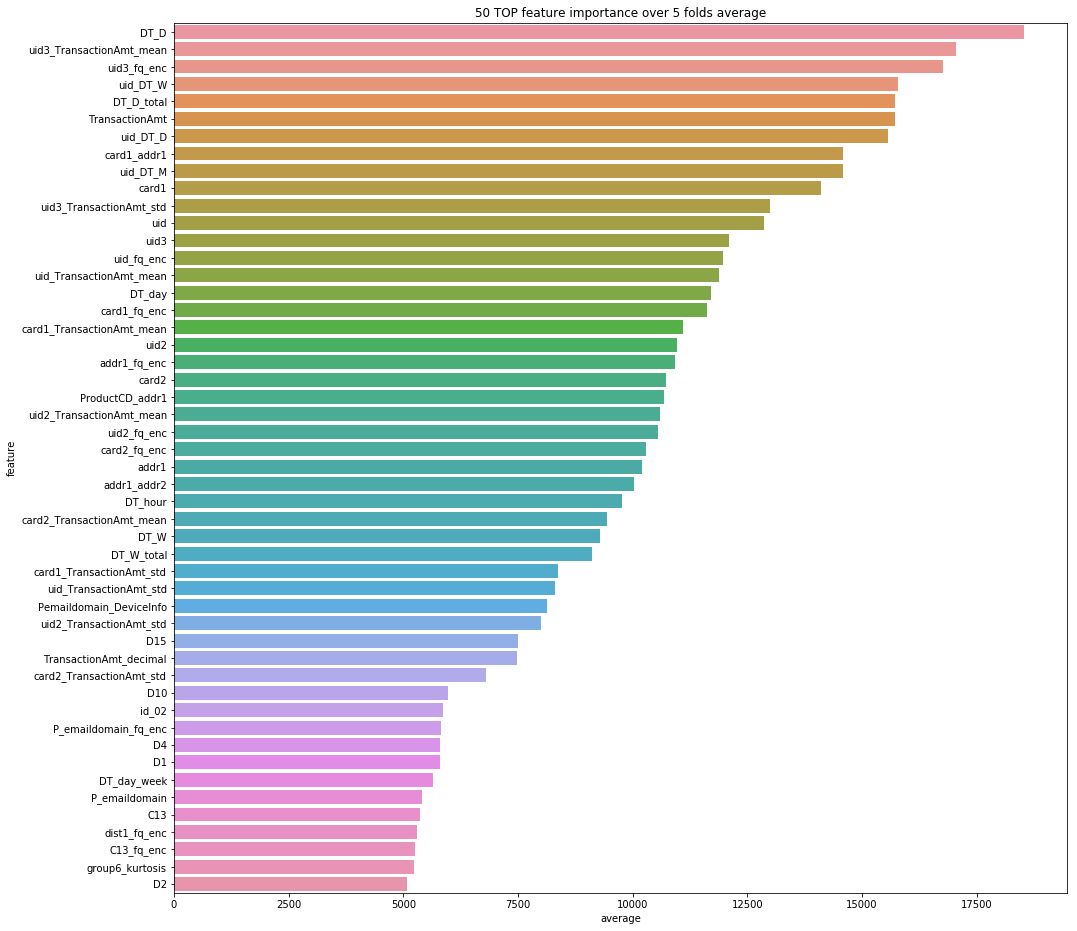

In [77]:
feature_importances['average'] = feature_importances[[f'fold_{fold_n + 1}' for fold_n in range(folds.n_splits)]].mean(axis=1)
feature_importances.to_csv('../importances/importances21.csv',index=False)

plt.figure(figsize=(16, 16))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(50), x='average', y='feature');
plt.title('50 TOP feature importance over {} folds average'.format(folds.n_splits));

In [78]:
!kaggle competitions submit -c ieee-fraud-detection -f ../predictions/pred21.csv -m "pred21"

100%|███████████████████████████████████████| 14.3M/14.3M [00:33<00:00, 442kB/s]
Successfully submitted to IEEE-CIS Fraud Detection

In [80]:
X = pd.concat([X,y],axis=1)

In [81]:
print(X.shape,X_test.shape)

(590540, 555) (506691, 554)


In [82]:
%%time
X.to_csv('../input/train9.csv',index=True)
X_test.to_csv('../input/test9.csv',index=True)

CPU times: user 7min 36s, sys: 2.67 s, total: 7min 39s
Wall time: 7min 39s
